# Binary Simplification in Metabolomics

Notebook to support the study on the application of **Bin**ary **Sim**plification as a competing form of pre-processing procedure for high-resolution metabolomics data.

This is notebook `paper_binsim_unsupervised.ipynb`


## Organization of the Notebook

- **Agglomerative Hierarchical Clustering and K-means Clustering: assessment of performence given a ground-truth of cluster assignments.**


#### Needed Imports

In [19]:
import itertools
from pathlib import Path

# json for persistence
import json
from time import perf_counter

import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker

import seaborn as sns

# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf

# Python files in the repository
import multianalysis as ma
from elips import plot_confidence_ellipse

In [20]:
%matplotlib inline

## Description of dataset records

`datasets` is the global dict that holds all data sets. It is a **dict of dict's**.

Each data set is **represented as a dict**.

Each record has the following fields (keys):

- `name`: the table/figure name of the data set
- `source`: the biological source for each dataset
- `mode`: the aquisition mode
- `alignment`: the alignment used to generate the data matrix
- `data`: the data matrix
- `target`: the sample labels, possibly already integer encoded
- `<treatment name>`: transformed data matrix. These treatment names can be
    - `Ionly`: missing value imputed data, only
    - `P`: Pareto scaled data
    - `NP`: Pareto scaled and normalized
    - `NGP`: normalized, glog transformed and Pareto scaled
    - `BinSim`: binary simplified data

The keys of `datasets` may be shared with dicts holding records resulting from comparison analysis.

Here are the keys (and respective names) of datasets used in this study:

- GD_neg_global2 (GDg2-)
- GD_pos_global2 (GDg2+)
- GD_neg_class2 (GDc2-)
- GD_pos_class2 (GDc2+)
- YD (YD 2/15)
- YD2 (YD 6/15)
- vitis_types (GD types)

## Load datasets

In [21]:
path = Path.cwd() / "paperimages" / 'processed_data.json'
storepath = Path.cwd() / "paperimages" / 'processed_data.h5'
with pd.HDFStore(storepath) as store:

    with open(path, encoding='utf8') as read_file:
        datasets = json.load(read_file)
    
    for dskey, dataset in datasets.items():
        for key in dataset:
            value = dataset[key]
            if isinstance(value, str) and value.startswith("INSTORE"):
                storekey = value.split("_", 1)[1]
                dataset[key] = store[storekey]
            elif key == 'label_colors':
                dataset[key] = {lbl: tuple(c) for lbl, c in value.items()}
            elif key == 'sample_colors':
                dataset[key] = [tuple(c) for c in value]

## Clustering methods

### Agglomerative Hierarchical Cluster Analysis 

HCA analysis of each differently-treated dataset and corresponding dendrograms.

**Euclidian distance** and **UPGMA linkage** used for datasets obtained with traditional pre-treatments.

Several **binary distance** metrics (Jaccard as example) and **UPGMA linkage** for datasets obtained with BinSim.

Note: `Vitis_types` data set was used only for supervised analysis and is thus not included here since unsupervised analysis does not depend on target labels (even if some of our metrics to evaluate them depend). For example, `Vitis_types` dendrograms would be equal to `GD_neg_class2` since the only difference between these data sets is the target labels.

In [22]:
def perform_HCA(df, metric='euclidean', method='average'):
    "Performs Hierarchical Clustering Analysis of a data set with chosen linkage method and distance metric."
    
    distances = dist.pdist(df, metric=metric)
    
    # method is one of
    # ward, average, centroid, single, complete, weighted, median
    Z = hier.linkage(distances, method=method)

    # Cophenetic Correlation Coefficient
    # (see how the clustering - from hier.linkage - preserves the original distances)
    coph = hier.cophenet(Z, distances)
    # Baker's gamma
    mr = ma.mergerank(Z)
    bg = mr[mr!=0]

    return {'Z': Z, 'distances': distances, 'coph': coph, 'merge_rank': mr, "Baker's Gamma": bg}

#### Computation of linkages, distances and cophenetics

- Ionly - Missing Value Imputation only (it is not performed for this one)
- P - Imputed and Pareto scaled
- NP - Imputed, Normalized (reference feature) and Pareto scaled
- NGP - Imputed, Normalized (reference feature), g-log transformed and Pareto scaled
- BinSim - Binary simplified data


Dictionaries to contain results

In [23]:
HCA_all = {}

Perform the clusterings

In [24]:
for name, ds in datasets.items():
    HCA_all[name] = {}
    for treat in 'P', 'NP', 'NGP', 'BinSim', 'P_RF', 'NP_RF', 'NGP_RF':
        print(f'Performing HCA to {name} data set with treatment {treat}', end=' ...')
        metric = 'jaccard' if treat == 'BinSim' else 'euclidean'
        HCA_all[name][treat] = perform_HCA(datasets[name][treat], metric=metric, method='average')
        print('done!')

Performing HCA to GD_neg_global2 data set with treatment P ...done!
Performing HCA to GD_neg_global2 data set with treatment NP ...done!
Performing HCA to GD_neg_global2 data set with treatment NGP ...done!
Performing HCA to GD_neg_global2 data set with treatment BinSim ...done!
Performing HCA to GD_neg_global2 data set with treatment P_RF ...done!
Performing HCA to GD_neg_global2 data set with treatment NP_RF ...done!
Performing HCA to GD_neg_global2 data set with treatment NGP_RF ...done!
Performing HCA to GD_pos_global2 data set with treatment P ...done!
Performing HCA to GD_pos_global2 data set with treatment NP ...done!
Performing HCA to GD_pos_global2 data set with treatment NGP ...done!
Performing HCA to GD_pos_global2 data set with treatment BinSim ...done!
Performing HCA to GD_pos_global2 data set with treatment P_RF ...done!
Performing HCA to GD_pos_global2 data set with treatment NP_RF ...done!
Performing HCA to GD_pos_global2 data set with treatment NGP_RF ...done!
Performi

In [25]:
# Older
def plot_dendogram(Z, leaf_names, label_colors=None, title='', color_threshold=None):
    """Plot a dendrogram from a Z linkage matrix with a chosen title and a chosen color_threshold."""
    
    with plt.rc_context({'lines.linewidth':1.5}):

        fig, ax = plt.subplots(figsize=(10,6))
        dn = hier.dendrogram(Z, labels=leaf_names, leaf_font_size=13, above_threshold_color='b', leaf_rotation=45,
                             color_threshold=color_threshold)#,  orientation='left')

        ax.set_ylabel('Distance (UA)')
        ax.set_title(title, fontsize = 16)
        # Coloring labels
        if label_colors is not None:
            for lbl in ax.get_xmajorticklabels():
                lbl.set_color(label_colors[lbl.get_text()])

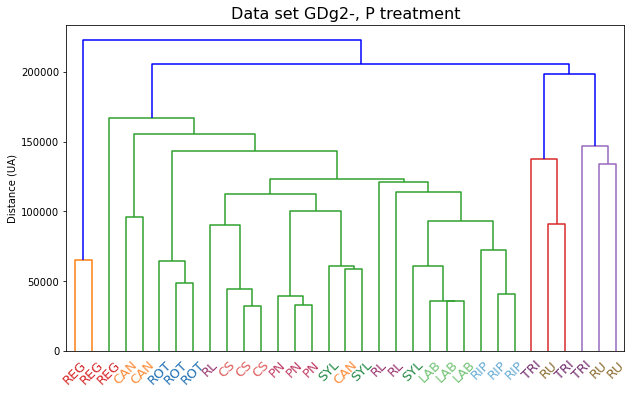

In [26]:
# GD, P for neg mode - GDg2-

name = 'GD_neg_global2'
title = f"Data set {datasets[name]['name']}, P treatment"
plot_dendogram(HCA_all[name]['P']['Z'],
               datasets[name]['target'],
               label_colors=datasets[name]['label_colors'], title=title,
               color_threshold=175000)

In [27]:
# alternative dendogram plots - Newer
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def color_list_to_matrix_and_cmap(colors, ind, axis=0):
        if any(issubclass(type(x), list) for x in colors):
            all_colors = set(itertools.chain(*colors))
            n = len(colors)
            m = len(colors[0])
        else:
            all_colors = set(colors)
            n = 1
            m = len(colors)
            colors = [colors]
        color_to_value = dict((col, i) for i, col in enumerate(all_colors))

        matrix = np.array([color_to_value[c]
                           for color in colors for c in color])

        matrix = matrix.reshape((n, m))
        matrix = matrix[:, ind]
        if axis == 0:
            # row-side:
            matrix = matrix.T

        cmap = mpl.colors.ListedColormap(all_colors)
        return matrix, cmap

def plot_dendogram2(Z, leaf_names, label_colors, title='', ax=None, no_labels=False, labelsize=12, **kwargs):
    if ax is None:
        ax = plt.gca()
    hier.dendrogram(Z, labels=leaf_names, leaf_font_size=10, above_threshold_color='0.2', orientation='left',
                    ax=ax, **kwargs)
    #Coloring labels
    #ax.set_ylabel('Distance (AU)')
    ax.set_xlabel('Distance (AU)')
    ax.set_title(title, fontsize = 15)
    
    #ax.tick_params(axis='x', which='major', pad=12)
    ax.tick_params(axis='y', which='major', labelsize=labelsize, pad=12)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #xlbls = ax.get_xmajorticklabels()
    xlbls = ax.get_ymajorticklabels()
    rectimage = []
    for lbl in xlbls:
        col = label_colors[lbl.get_text()]
        lbl.set_color(col)
        #lbl.set_fontweight('bold')
        if no_labels:
            lbl.set_color('w')
        rectimage.append(col)

    cols, cmap = color_list_to_matrix_and_cmap(rectimage, range(len(rectimage)), axis=0)

    axins = inset_axes(ax, width="5%", height="100%",
                   bbox_to_anchor=(1, 0, 1, 1),
                   bbox_transform=ax.transAxes, loc=3, borderpad=0)

    axins.pcolor(cols, cmap=cmap, edgecolors='w', linewidths=1)
    axins.axis('off')

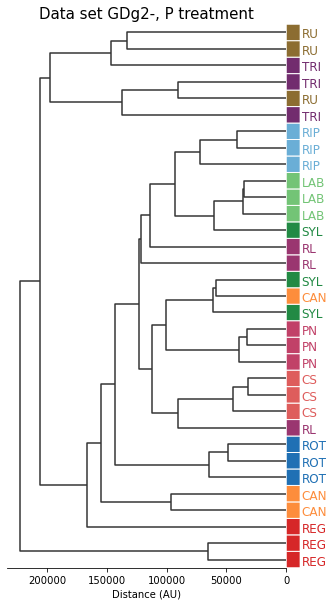

In [28]:
# GD, P for neg mode - GDg2-
f, ax = plt.subplots(figsize=(5, 10))
name = 'GD_neg_global2'
title = f"Data set {datasets[name]['name']}, P treatment"
plot_dendogram2(HCA_all[name]['P']['Z'], 
               datasets[name]['target'], ax=ax,
               label_colors=datasets[name]['label_colors'], title=title,
               color_threshold=0)

<span style="color:darkred;">------- Checkpoint for API migration</span>

In [29]:
Z = HCA_all['GD_neg_global2']['P']['Z']

col_names = 'cluster a', 'cluster b', 'd(a,b)', '# cluster a-b'
df_Z = pd.DataFrame(Z, index=range(1, len(Z)+1), columns=col_names)
df_Z.index.name = 'iteration'
df_Z.insert(2, 'new cluster', pd.Series(range(len(Z), 2*len(Z)+1)))

new_dtypes = {'cluster a': 'int64', 'cluster b': 'int64', '# cluster a-b': 'int64', 'new cluster': 'int64'}
df_Z = df_Z.astype(new_dtypes)

roundrobin = pd.read_csv('df_Z_P_neg.csv', sep='\t', index_col=0)

assert_frame_equal(roundrobin, df_Z)
#roundrobin

#df_Z

<span style="color:darkred;">------- END checkpoint for API migration</span>

#### Dendrograms of the 4 differently-treated data sets for each of the 6 benchmark data sets

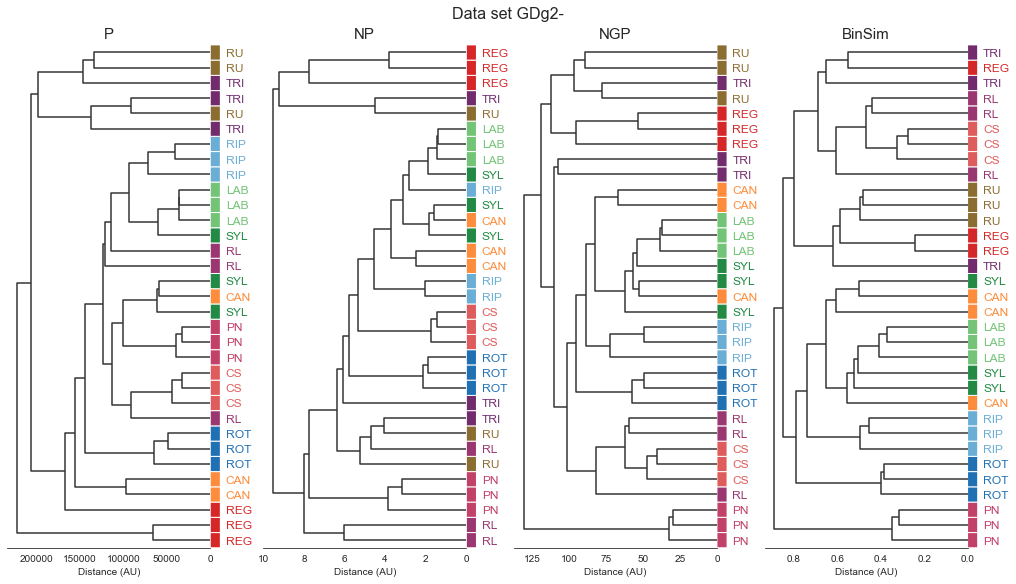

In [30]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(14, 8), constrained_layout=True)
    
    name = 'GD_neg_global2'
    
    for treatment, ax in zip(('P', 'NP', 'NGP', 'BinSim'), axs.ravel()):
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle(f"Data set {datasets[name]['name']}", fontsize=16)
    plt.show()

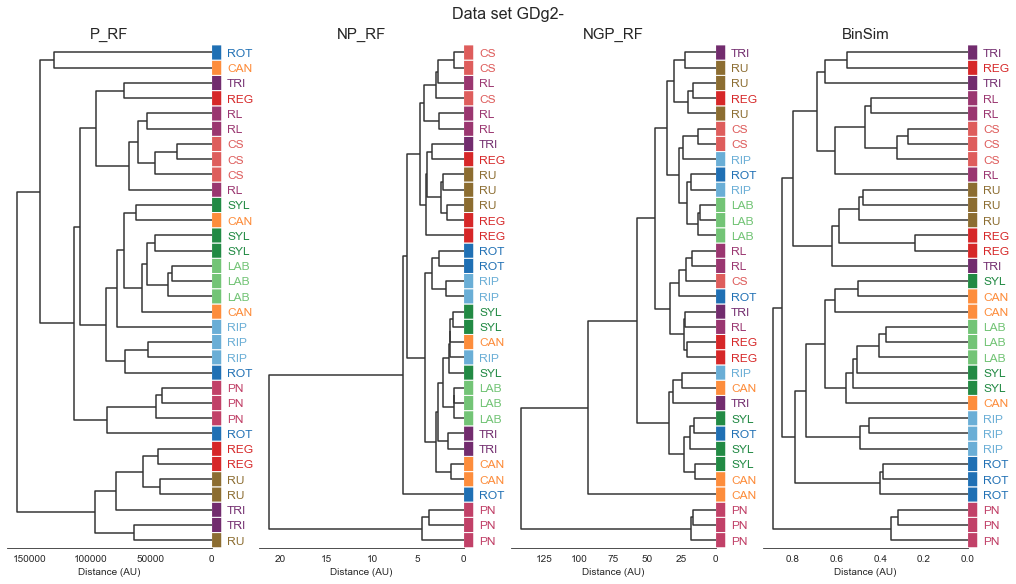

In [31]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(14, 8), constrained_layout=True)
    
    name = 'GD_neg_global2'
    
    for treatment, ax in zip(('P_RF', 'NP_RF', 'NGP_RF', 'BinSim'), axs.ravel()):
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle(f"Data set {datasets[name]['name']}", fontsize=16)
    plt.show()

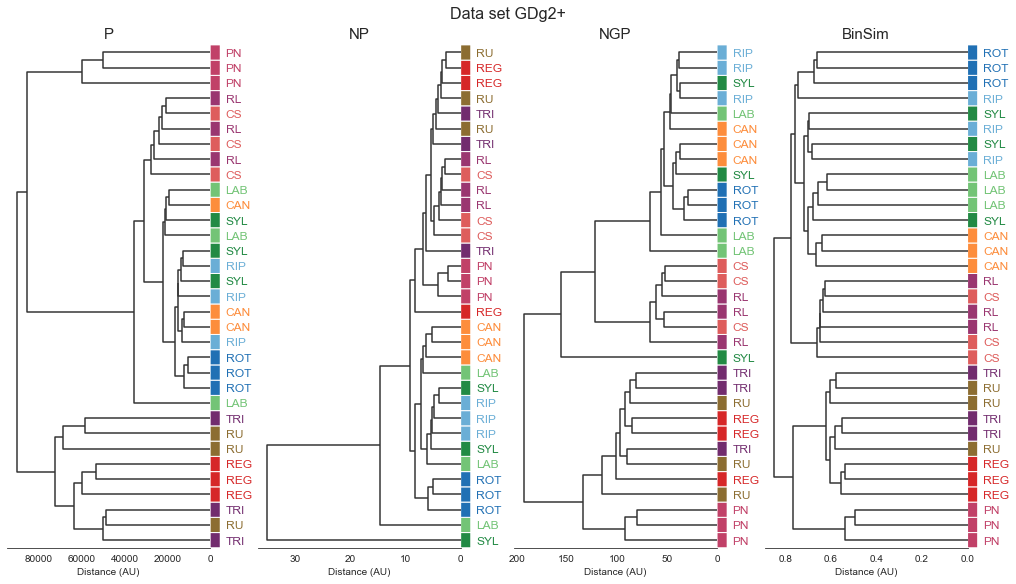

In [32]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(14, 8), constrained_layout=True)
    
    name = 'GD_pos_global2'
      
    for treatment, ax in zip(('P', 'NP', 'NGP', 'BinSim'), axs.ravel()):
        color_threshold = 0.68 if treatment == 'BinSim' else None
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle(f"Data set {datasets[name]['name']}", fontsize=16)
    plt.show()

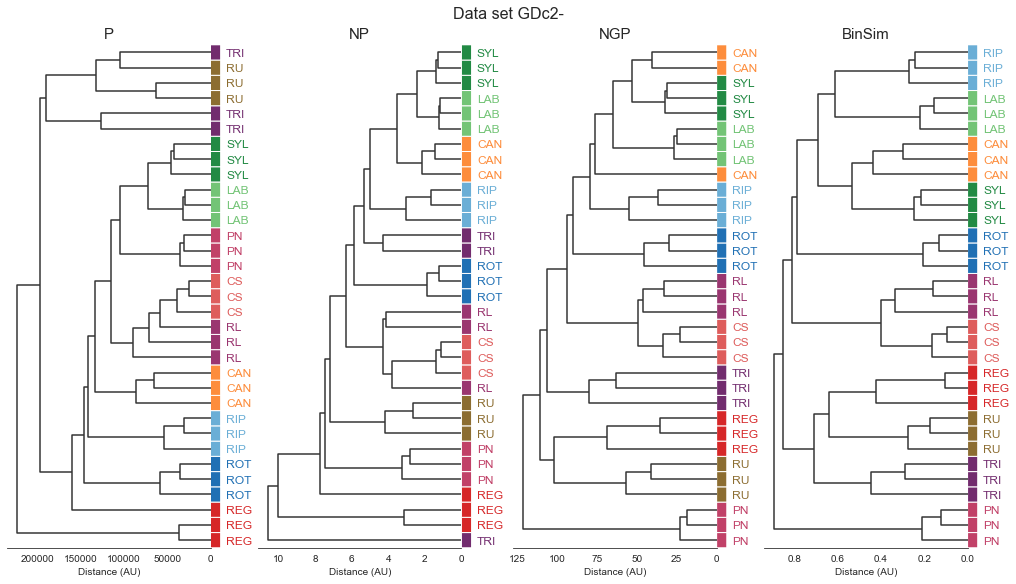

In [33]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(14, 8), constrained_layout=True)
    
    name = 'GD_neg_class2'
      
    for treatment, ax in zip(('P', 'NP', 'NGP', 'BinSim'), axs.ravel()):
        color_threshold = 0.68 if treatment == 'BinSim' else None
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle(f"Data set {datasets[name]['name']}", fontsize=16)
    plt.show()

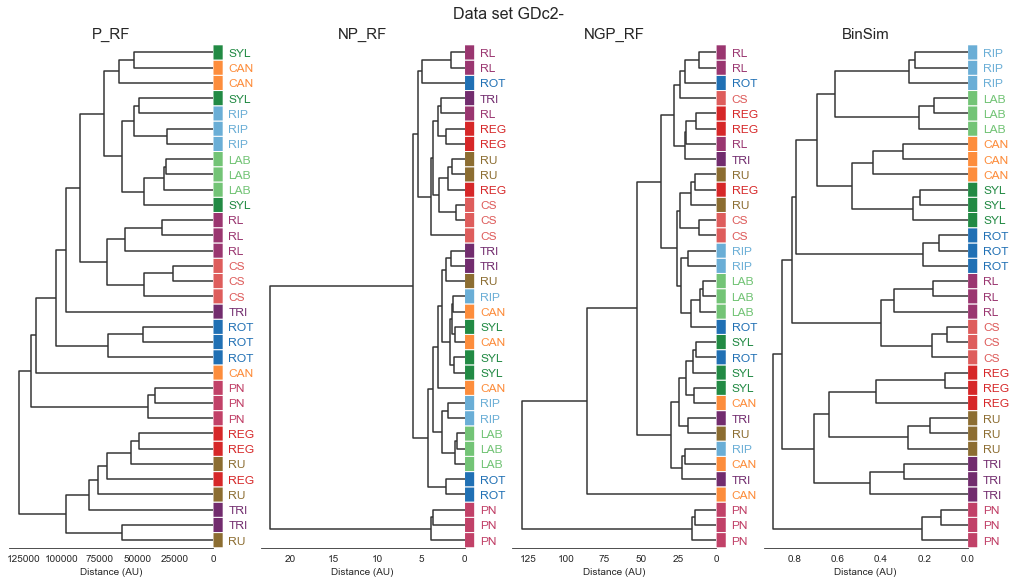

In [34]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(14, 8), constrained_layout=True)
    
    name = 'GD_neg_class2'
      
    for treatment, ax in zip(('P_RF', 'NP_RF', 'NGP_RF', 'BinSim'), axs.ravel()):
        color_threshold = 0.68 if treatment == 'BinSim' else None
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle(f"Data set {datasets[name]['name']}", fontsize=16)
    plt.show()

Data set GDc2+ (titles not shown - image for paper)

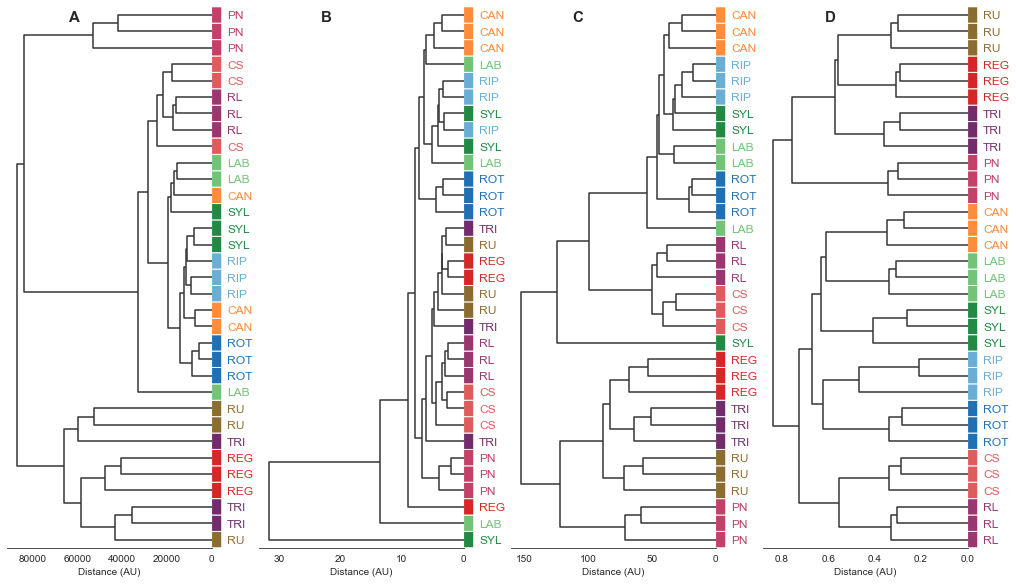

In [35]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(14, 8), constrained_layout=True)
    
    name = 'GD_pos_class2'
      
    for treatment, ax in zip(('P', 'NP', 'NGP', 'BinSim'), axs.ravel()):
        color_threshold = 0.68 if treatment == 'BinSim' else None
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title='', color_threshold=0)

    #st = f.suptitle(f"Data set {datasets[name]['name']}", fontsize=16)
    for letter, ax in zip('ABCDEFGHIJ', axs.ravel()):
        ax.text(0.3, 0.98, letter, ha='left', va='center', fontsize=15, weight='bold',
                transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.9))

    plt.show()
    f.savefig('paperimages/dendrosGDpos21.pdf', dpi=200)
    f.savefig('paperimages/dendrosGDpos21.png', dpi=600)

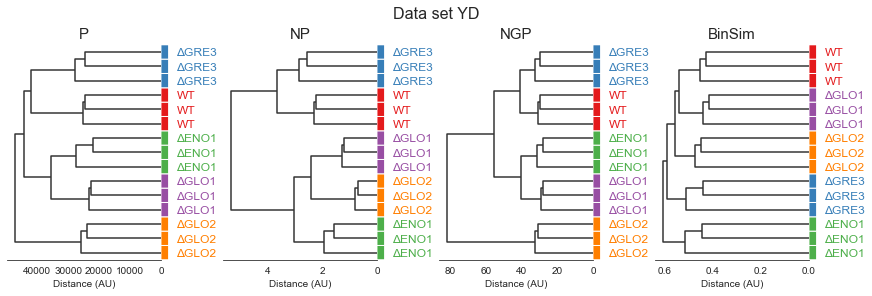

In [36]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(12, 4), constrained_layout=True)
    
    name = 'YD'
      
    for treatment, ax in zip(('P', 'NP', 'NGP', 'BinSim'), axs.ravel()):
        color_threshold = 0.68 if treatment == 'BinSim' else None
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle('Data set YD', fontsize=16)
    plt.show()

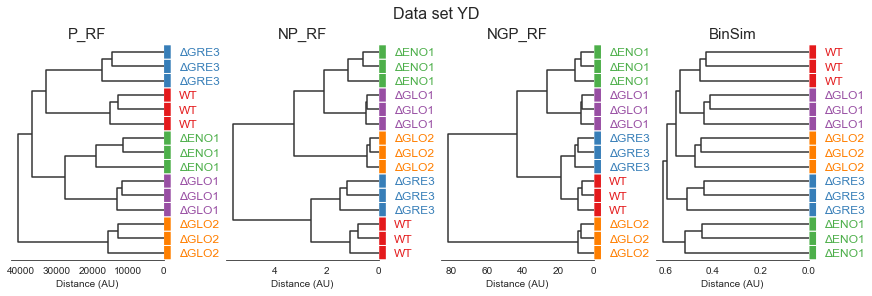

In [37]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(12, 4), constrained_layout=True)
    
    name = 'YD'
      
    for treatment, ax in zip(('P_RF', 'NP_RF', 'NGP_RF', 'BinSim'), axs.ravel()):
        color_threshold = 0.68 if treatment == 'BinSim' else None
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle('Data set YD', fontsize=16)
    plt.show()

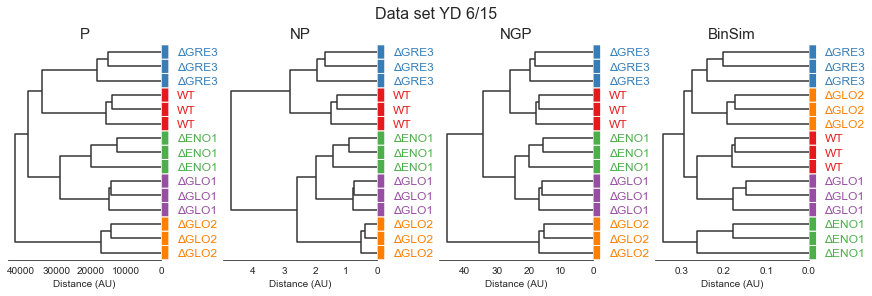

In [38]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(12, 4), constrained_layout=True)
    
    name = 'YD2'
      
    for treatment, ax in zip(('P', 'NP', 'NGP', 'BinSim'), axs.ravel()):
        color_threshold = 0.68 if treatment == 'BinSim' else None
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle(f'Data set {datasets[name]["name"]}', fontsize=16)
    plt.show()

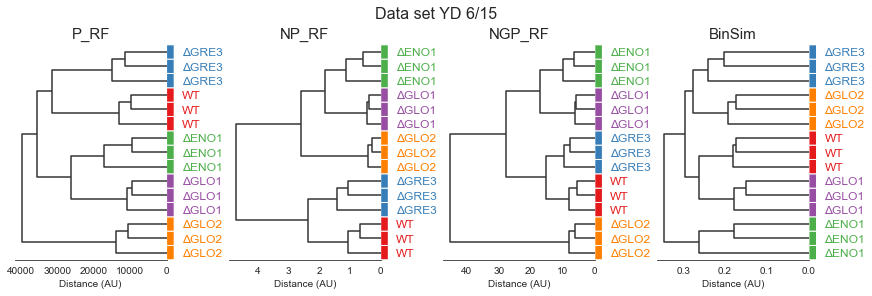

In [39]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(12, 4), constrained_layout=True)
    
    name = 'YD2'
      
    for treatment, ax in zip(('P_RF', 'NP_RF', 'NGP_RF', 'BinSim'), axs.ravel()):
        color_threshold = 0.68 if treatment == 'BinSim' else None
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle(f'Data set {datasets[name]["name"]}', fontsize=16)
    plt.show()

###  Dendrogram Similarity Comparison

The similarity of the dendrograms built from the differently-treated data sets of each of the benchmark data sets were compared using two correlation coefficients:

#### Cophenetic Correlation Coefficient

- Pearson Correlation of the matrix of cophenetic distances of two dendrograms.

#### Baker's Gamma Correlation Coefficient

- Use of the `mergerank` function from multianalysis.py to create a 'rank' of the iteration number two samples were linked to the same cluster. Then see Kendall Correlation between the results from 2 dendrograms according to Baker's paper or Spearman Correlation according to explanation given in the R package `dendextend`.

Baker's paper: Baker FB. Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors. J Am Stat Assoc. 1974;69(346):440-445. doi:10.2307/2285675

The information from HCA for these methods is already collected for the intensity-based pre-treatment treated data sets (and for BinSim treated data sets using the Jaccard distance for HCA) but it is not collected for BinSim treated data sets for other binary distance metrics. Thus, it will also be collected for these other binary distance metrics to compare the similarity of their dendrograms.

#### Examples of procedure with these methods with the Negative Grapevine Dataset - GDg2-

In [40]:
# Correation metrics
pearsonr = stats.pearsonr
kendalltau = stats.kendalltau
spearmanr = stats.spearmanr

table = []
t1 = HCA_all['GD_neg_global2']['P']
t2 = HCA_all['GD_neg_global2']['NP']
t3 = HCA_all['GD_neg_global2']['NGP']

r, p_value = pearsonr(t1['coph'][1], t2['coph'][1])
k, p_value_k = kendalltau(t1["Baker's Gamma"], t2["Baker's Gamma"])
s, p_value_s = spearmanr(t1["Baker's Gamma"], t2["Baker's Gamma"])
table.append({'Pair of samples': 'P Treat-NP Treat',
              'Cophenetic (Pearson)': r,
              '(coph) p-value': p_value,
              "Baker's (Kendall)":k,
              '(B-K) p-value': p_value_k,
              "Baker's (Spearman)":s,
              '(B-S) p-value': p_value_s,})

r, p_value = pearsonr(t1['coph'][1], t3['coph'][1])
k, p_value_k = kendalltau(t1["Baker's Gamma"], t3["Baker's Gamma"])
s, p_value_s = spearmanr(t1["Baker's Gamma"], t3["Baker's Gamma"])
table.append({'Pair of samples': 'P Treat-NGP Treat',
              'Cophenetic (Pearson)': r,
              '(coph) p-value': p_value,
              "Baker's (Kendall)":k,
              '(B-K) p-value': p_value_k,
              "Baker's (Spearman)":s,
              '(B-S) p-value': p_value_s,})

pd.DataFrame(table).set_index('Pair of samples')

,Cophenetic (Pearson),(coph) p-value,Baker's (Kendall),(B-K) p-value,Baker's (Spearman),(B-S) p-value
Pair of samples,,,,,,
P Treat-NP Treat,0.610481,3.108863e-55,0.443301,2.817915e-81,0.568441,2.054162e-91
P Treat-NGP Treat,0.580429,7.105127e-49,0.350714,2.271963e-50,0.434035,9.513613e-50


### BinSim Treated Datasets: behaviour of different binary distance measures in HCA

#### Part 1 (Perform HCAs to BinSim treated datasets using different binary distance measures)

**Note**: Applied to GDg2 data sets only, Negative and Positive modes.

In [41]:
# 9 binary distance metrics accepted in pdist (scipy.spatial.distances.pdist)
binary_metrics = ('dice', 'hamming', 'jaccard', 'rogerstanimoto',
                  'sokalmichener', 'sokalsneath', 'yule', 'kulsinski',
                  'russellrao')
# 3 metrics that will be used as representative of the others
#(others not present have similar variations to one of those 3)
#binary = ( 'jaccard', 'hamming', 'yule')

In [42]:
# complement with HCA based on other binary distances using the BinSim treatment matrices

ds2use = 'GD_neg_global2', 'GD_pos_global2'

for name in ds2use:
    for bin_metric in binary_metrics:
        print(f'Performing HCA to {name} BinSim data set with metric {bin_metric}', end=' ...')
        HCA_all[name][bin_metric] = perform_HCA(datasets[name]['BinSim'], metric=bin_metric, method='average')
        print('done!')

Performing HCA to GD_neg_global2 BinSim data set with metric dice ...done!
Performing HCA to GD_neg_global2 BinSim data set with metric hamming ...done!
Performing HCA to GD_neg_global2 BinSim data set with metric jaccard ...done!
Performing HCA to GD_neg_global2 BinSim data set with metric rogerstanimoto ...done!
Performing HCA to GD_neg_global2 BinSim data set with metric sokalmichener ...done!
Performing HCA to GD_neg_global2 BinSim data set with metric sokalsneath ...done!
Performing HCA to GD_neg_global2 BinSim data set with metric yule ...done!
Performing HCA to GD_neg_global2 BinSim data set with metric kulsinski ...done!
Performing HCA to GD_neg_global2 BinSim data set with metric russellrao ...done!
Performing HCA to GD_pos_global2 BinSim data set with metric dice ...done!
Performing HCA to GD_pos_global2 BinSim data set with metric hamming ...done!
Performing HCA to GD_pos_global2 BinSim data set with metric jaccard ...done!
Performing HCA to GD_pos_global2 BinSim data set wi

### Part 2 (Calculate all the pairwise correlations between the dendrograms)

Choose the set of treatment/distance metric combination to consider to calculate the pairwise correlations. These are indicated by the strings in the treatments list. The colnames list has to follow the same logic as the treatments list.

#### GDg2 with 3 different binary distance metrics (Jaccard, Hamming and Yule) and the 3 intensity-based pre-treatments (P, NP and NGP)

In [43]:
# Column names and row names for the dataframes and heatmaps
# Collect results of HCAs

colnames = ['P', 'NP', 'NGP','J' , 'H', 'Y']
treatments = ['P', 'NP', 'NGP','jaccard' , 'hamming', 'yule']

# Calculation of correlation coefficient by each method

def create_HCA_correlations(HCA_results, treatments, colnames):
    n_res = len(colnames)
    correlations = {key: np.empty((n_res, n_res)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

    for i, treat1 in enumerate(treatments):
        for j, treat2 in enumerate(treatments):
            Si, Sj = HCA_results[treat1], HCA_results[treat2]
            # K - Kendall (Baker's Gamma)
            k, p_value_k = stats.kendalltau(Si["Baker's Gamma"], Sj["Baker's Gamma"])
            correlations['K'][i,j], correlations['K_p'][i,j] = k, p_value_k

            # S - Spearman (Baker's Gamma)
            s, p_value_s = stats.spearmanr(Si["Baker's Gamma"], Sj["Baker's Gamma"])
            correlations['S'][i,j], correlations['S_p'][i,j] = s, p_value_s

            # C - Cophenetic Correlation
            r, p_value = stats.pearsonr(Si['coph'][1], Sj['coph'][1])
            correlations['C'][i,j], correlations['C_p'][i,j] = r, p_value

    for k in correlations:
        correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)
    return correlations

correlations_neg = create_HCA_correlations(HCA_all['GD_neg_global2'], treatments, colnames)
correlations_pos = create_HCA_correlations(HCA_all['GD_pos_global2'], treatments, colnames)

### Part 3 (Heatmaps of the correlation coeficients)

As for the Baker's Gamma Correlation, the heatmaps presented will be the ones with corelation calculated with Kendall correlation (according to the original paper - Baker FB. Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors. J Am Stat Assoc. 1974;69(346):440-445. doi:10.2307/2285675).

Although, seeing the other correlations is just a case of changing the 'C's and 'K's to 'S's based on which set of correlations you want to see in the `combineCK` function (2 cells below).

Here, **two sets of heatmaps** that mimic the figures presented in the paper are shown - Baker's gamma (Kendall) correlation (upper) and cophenetic correlation (lower) of the GDg2- or GDg2+ data sets with 3 different binary distance metrics (Jaccard, Hamming and Yule) and the 3 combinations of intensity-based pre-treatments.

Then, **one heatmap (cophenetic correlation coefficient)** with the 9 binary distance metrics (and the 3 combinations of intensity-based pre-treatments) for both the GDg2- and GDg2+ at the same time are shown.


Below, are the functions to build these heatmaps.

In [44]:
def relative_luminance(color):
    """Calculate the relative luminance of a color according to W3C standards
    Parameters
    ----------
    color : matplotlib color or sequence of matplotlib colors
        Hex code, rgb-tuple, or html color name.
    Returns
    -------
    luminance : float(s) between 0 and 1
    """
    rgb = mpl.colors.to_rgba_array(color)[:, :3]
    rgb = np.where(rgb <= .03928, rgb / 12.92, ((rgb + .055) / 1.055) ** 2.4)
    lum = rgb.dot([.2126, .7152, .0722])
    try:
        return lum.item()
    except ValueError:
        return lum

def plot_partitioned_df_asheatmap(df, ax=None, cmap='viridis', vmin=None, vmax=None, norm=None,
                                  partition_point=0, top_rotate=False, fontsize=14, colorbar=True):
    
    if ax is None:
        ax = plt.gca()
    
    values = df.values.copy()
    #values = np.flipud(values)
    # handle partition point
    
    # insert NaN column/row in values
    values = np.insert(values, partition_point, np.nan, axis=1)
    #values = np.insert(values, df.shape[0]- partition_point, np.nan, axis=0)
    values = np.insert(values, partition_point, np.nan, axis=0)
    
    # compute and insert 2% offset
    X = np.array(range(values.shape[0] + 1), dtype=float)
    Y = np.array(range(values.shape[1] + 1), dtype=float)
    offset = X[-1] * 0.02
    
    X[(partition_point+1):] = np.arange(float(partition_point)+offset, float(len(X)-1), 1.0)
    Y[(partition_point+1):] = np.arange(float(partition_point)+offset, float(len(Y)-1), 1.0)
    #Y[(len(Y)-partition_point-1):] = np.arange(float(len(Y)-partition_point-2)+offset, float(len(Y)-1), 1.0)

    # draw pcolormesh
    pm = ax.pcolormesh(X, Y, values, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
    ax.set_ylim(ax.get_ylim()[1], ax.get_ylim()[0])
    ax.set_aspect('equal')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # handle labels
    midpoints_x = (X[1:] - X[:-1]) / 2 + X[:-1]
    midpoints_x = np.delete(midpoints_x, partition_point)
    midpoints_y = (Y[1:] - Y[:-1]) / 2 + Y[:-1]
    midpoints_y = np.delete(midpoints_y, partition_point)
    ax.set_xticks(midpoints_x)
    ax.set_yticks(midpoints_y)
    ax.set_xticklabels(df.columns)
    ax.set_yticklabels(df.index)
    ax.tick_params(labeltop=True, labelbottom=False, labelsize=fontsize,
                   top=False, bottom=False, left=False, right=False)
    if top_rotate:
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va='center', rotation_mode="anchor")
    
    # handle annotations
    
    pm_colors = pm.cmap(pm.norm(pm.get_array())).reshape(values.shape[0], values.shape[1], 4)
    mask = np.ones((values.shape[0], values.shape[1]), dtype=bool)
    mask[:, partition_point] = False
    mask[partition_point, :] = False
    pm_colors = pm_colors[mask].reshape(df.shape[0], df.shape[1], 4)
    #print(pm_colors)

    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            locx = midpoints_x[j]
            locy = midpoints_y[i]
            # handle label color according to cell color
            cell_color = pm_colors[i, j, :]
            lum = relative_luminance(cell_color)
            text_color = ".15" if lum > .408 else "w"
            annot = f'{df.iloc[i, j]:.2g}'
            text = ax.text(locx, locy, annot, fontsize=fontsize,
                           ha="center", va="center", color=text_color)

    if colorbar:
        plt.colorbar(pm)
    return pm

In [45]:
def combineCK(correlations):
    correlations['CK'] = correlations['C'].copy()
    # lower tringular mask
    upper_mask = np.triu(np.ones(correlations['CK'].shape)).astype(bool)
    correlations['CK'][upper_mask] = correlations['K']

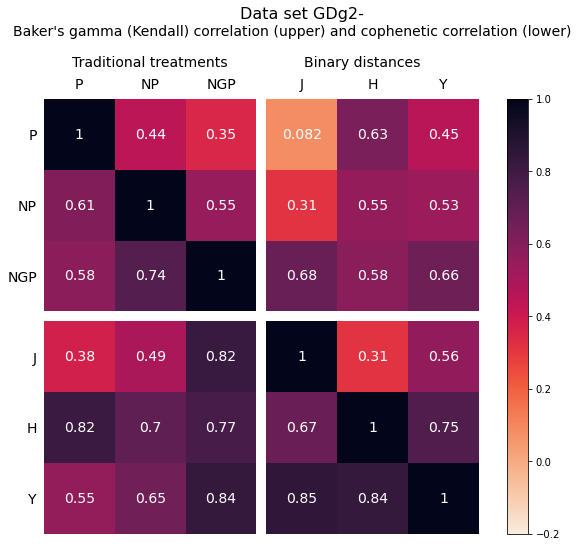

In [46]:
f, ax = plt.subplots(figsize=(10,8))

combineCK(correlations_neg)

pm = plot_partitioned_df_asheatmap(correlations_neg['CK'], ax=ax, vmin=-0.2, vmax=1,
                                    cmap=sns.color_palette("rocket_r", as_cmap=True),
                                    partition_point=3, top_rotate=False)
ax.text(3.5, -0.9, "Baker's gamma (Kendall) correlation (upper) and cophenetic correlation (lower)",
        ha='center', fontsize=14)

f.suptitle("Data set GDg2-", fontsize=16, y=1.04)
ax.text(1.5,-0.45, 'Traditional treatments', fontsize=14, ha='center')
ax.text(4.5,-0.45, 'Binary distances', fontsize=14, ha='center')

plt.show()

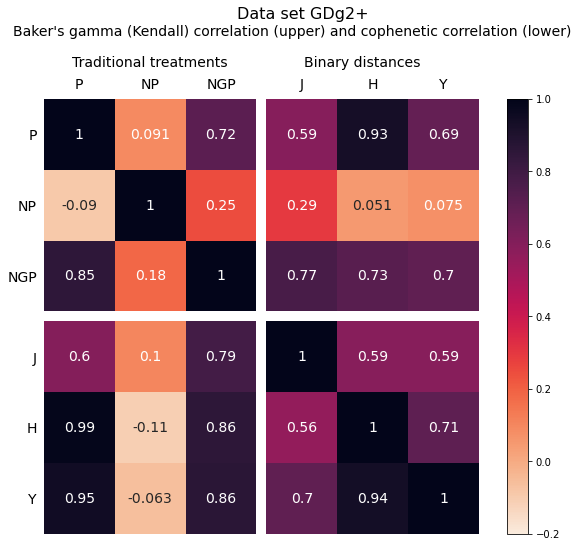

In [47]:
f, ax = plt.subplots(figsize=(10,8))

combineCK(correlations_pos)

pm = plot_partitioned_df_asheatmap(correlations_pos['CK'], ax=ax, vmin=-0.2, vmax=1,
                                    cmap=sns.color_palette("rocket_r", as_cmap=True),
                                    partition_point=3, top_rotate=False)
ax.text(3.5, -0.9, "Baker's gamma (Kendall) correlation (upper) and cophenetic correlation (lower)",
        ha='center', fontsize=14)

f.suptitle("Data set GDg2+", fontsize=16, y=1.04)
ax.text(1.5,-0.45, 'Traditional treatments', fontsize=14, ha='center')
ax.text(4.5,-0.45, 'Binary distances', fontsize=14, ha='center')

plt.show()

#### Heatmaps combined in a single figure

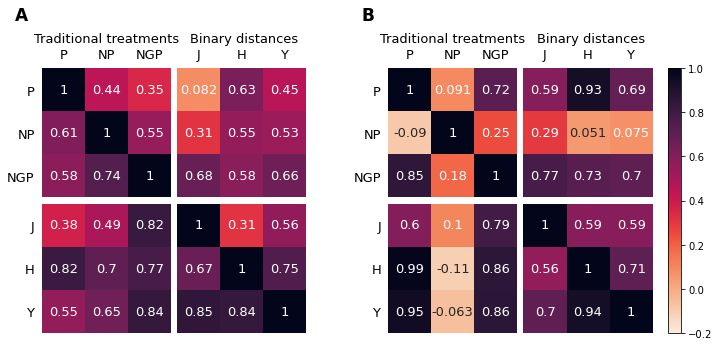

In [48]:
f, (axl, axr) = plt.subplots(1,2, figsize=(10,4.7), constrained_layout=True)

combineCK(correlations_neg)

pm = plot_partitioned_df_asheatmap(correlations_neg['CK'], ax=axl, vmin=-0.2, vmax=1,
                                    cmap=sns.color_palette("rocket_r", as_cmap=True), fontsize=13,
                                    partition_point=3, top_rotate=False, colorbar=False)
#axl.set_title("Data set GDg2-", fontsize=16, y=1.15)
axl.text(1.5,-0.6, 'Traditional treatments', fontsize=13, ha='center')
axl.text(4.7,-0.6, 'Binary distances', fontsize=13, ha='center')

combineCK(correlations_pos)

pm = plot_partitioned_df_asheatmap(correlations_pos['CK'], ax=axr, vmin=-0.2, vmax=1,
                                    cmap=sns.color_palette("rocket_r", as_cmap=True), fontsize=13,
                                    partition_point=3, top_rotate=False)

#axr.set_title("Data set GDg2+", fontsize=16, y=1.15)
axr.text(1.5,-0.6, 'Traditional treatments', fontsize=13, ha='center')
axr.text(4.7,-0.6, 'Binary distances', fontsize=13, ha='center')

for letter, ax in zip('ABCDEFGHIJ', (axl, axr)):
    ax.text(-0.1, 1.2, letter, ha='left', va='center', fontsize=17, weight='bold',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='white', alpha=0.9))


f.savefig('paperimages/coph_baker_corrs.pdf', dpi=400)
f.savefig('paperimages/coph_baker_corrs.png', dpi=600)

plt.show()

### Heatmap with all treatment/distance metrics for both GDg2 data sets - Example with all 9 binary distance metrics

Change the treatments and colnames list to account for all binary distance metrics and the two ionization modes.

In [49]:
colnames = ['P -', 'NP -', 'NGP -', 'P +', 'NP +', 'NGP +','dice -', 'hamming -',
            'jaccard -', 'rogerstanimoto -', 'sokalmichener -', 'sokalsneath -','yule -', 
            'kulsinski -', 'russellrao -','dice +', 'hamming +', 'jaccard +', 'rogerstanimoto +', 
            'sokalmichener +', 'sokalsneath +', 'yule +', 'kulsinski +', 'russellrao +']

treatments = colnames

collectedHCAs = {}
for name in treatments:
    tname, mode = name.split()
    if mode == '-':
        collectedHCAs[name] = HCA_all['GD_neg_global2'][tname]
    else:
        collectedHCAs[name] = HCA_all['GD_pos_global2'][tname]

In [50]:
all_correlations = create_HCA_correlations(collectedHCAs, treatments, colnames)

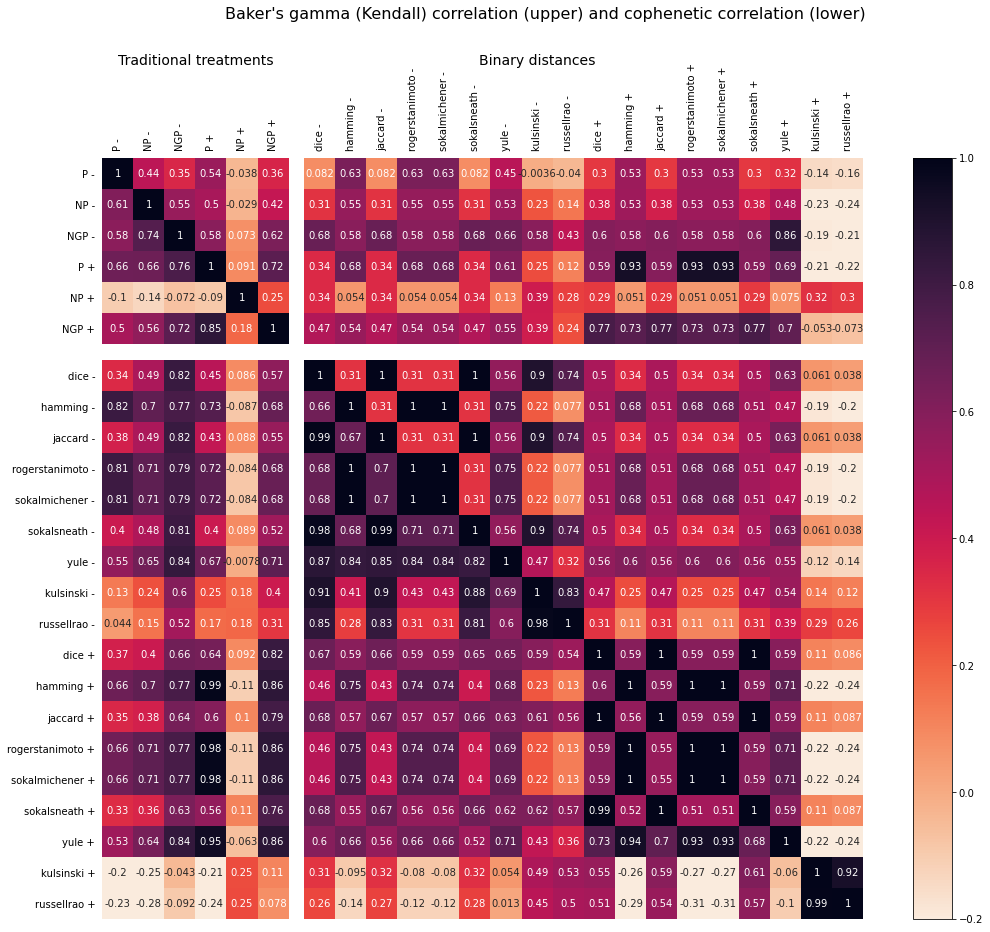

In [52]:
f, ax = plt.subplots(figsize=(18,14))

combineCK(all_correlations)

pm = plot_partitioned_df_asheatmap(all_correlations['CK'], ax=ax, vmin=-0.2, vmax=1, fontsize=10,
                                    cmap=sns.color_palette("rocket_r", as_cmap=True),
                                    partition_point=6, top_rotate=True)

f.suptitle("Baker's gamma (Kendall) correlation (upper) and cophenetic correlation (lower)", fontsize=16, y=1.03)

ax.text(3,-3, 'Traditional treatments', fontsize=14, ha='center')
ax.text(14,-3, 'Binary distances', fontsize=14, ha='center')

plt.show()

## Evaluating Dendrogram (HCAs) Sample Discrimination

To evaluate the discrimination achieved with each HCA, 3 different metrics were used (explained in the paper):

- **Discrimination Distance** - the average of “group discrimination distance”. For each group, the discrimination distance is 0 if the group is not “correctly clustered” or it is the distance between the node that includes all the samples of the group and the next closest node (including those samples) in the agglomerative procedure, normalized by the maximum distance of any pair of nodes in the final resulting clustering.
- **Correct Clustering Percentage** - the percentage of the groups who are correctly clustered.
- **Correct First Cluster Percentage** - the percentage of samples whose first clustering was only with a sample(s) from its group.

Correct (Group) Clustering definition - samples of a group all clustered together before any other clustering with other samples or already-formed clusters in the agglomerative procedure.

Functions applied here (`dist_discrim` and `correct_1stcluster_fraction`) from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

In [53]:
def compute_clustering_metrics(res_dict, labels):
    """Fill dict with clustering performance metrics."""
    
    discrim = ma.dist_discrim(res_dict['Z'], labels, # all samples have the same order
                              method = 'average')
    res_dict['Average discrim dist'] = discrim[0]
    correct = np.array(list(discrim[1].values()))
    
    classes = pd.unique(labels)
    res_dict['% correct clustering'] = (100/len(classes)) * len(correct[correct>0])

    # Correct First Cluster Percentage
    res_dict['% correct 1st clustering'] = 100 * ma.correct_1stcluster_fraction(res_dict['Z'],labels)
    

Compute clustering metrics for the dendrograms built from the GDg2- and GDg2+ data sets treated with one of 3 combinations of intensity-based pre-treatments or with BinSim with one of nine binary distance metrics.

In [54]:
# collectedHCAs exists!

for name, res_dict in collectedHCAs.items():
    compute_clustering_metrics(res_dict, datasets['GD_pos_class2']['target'])

In [55]:
# Build table - summary of results
clust_performance = {}

for metric in ('Average discrim dist', '% correct clustering', '% correct 1st clustering'):
    clust_performance[metric] = {d: collectedHCAs[d][metric] for d in collectedHCAs}
clust_performance = pd.DataFrame(clust_performance, index=collectedHCAs)
clust_performance

,Average discrim dist,% correct clustering,% correct 1st clustering
P -,0.094914,45.454545,63.636364
NP -,0.124395,45.454545,63.636364
NGP -,0.138279,54.545455,78.787879
P +,0.033682,27.272727,33.333333
NP +,0.014673,27.272727,27.272727
NGP +,0.025067,18.181818,48.484848
dice -,0.173747,54.545455,66.666667
hamming -,0.119555,45.454545,69.696970
jaccard -,0.154588,54.545455,66.666667
rogerstanimoto -,0.124665,45.454545,69.696970


In [56]:
clust_performance_pos = clust_performance[clust_performance.index.str.endswith('+')]
clust_performance_neg = clust_performance[clust_performance.index.str.endswith('-')]
#clust_performance_neg

#### Clustering Results 

All different binary distance measures lead to similar results, so Jaccard dissimilarity will represent the binary distance metrics for all the 6 benchmark data sets.

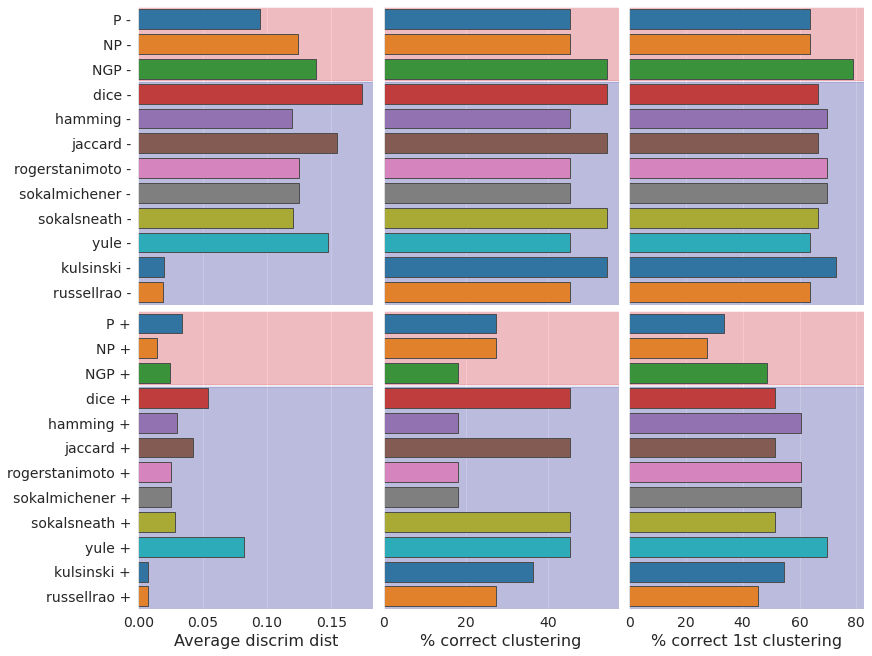

In [57]:
with sns.axes_style("darkgrid"):
    f, axs = plt.subplots(2, 3, figsize=(12, 9), sharey='row', sharex='col', constrained_layout=True)
    for ax in axs.ravel():
        ax.tick_params(labelsize=14)
        ax.xaxis.label.set_size(16)
        ax.axhspan(-0.5, 2.45, color='red', alpha=0.2)
        ax.axhspan(2.55, 11.5, color='darkblue', alpha=0.2)
    sns.barplot(y=clust_performance_neg.index, x=clust_performance_neg['% correct clustering'], ax=axs[0][1], palette='tab10', ec='0.3')
    sns.barplot(y=clust_performance_neg.index, x=clust_performance_neg['% correct 1st clustering'], ax=axs[0][2], palette='tab10', ec='0.3')
    sns.barplot(y=clust_performance_neg.index, x=clust_performance_neg['Average discrim dist'], ax=axs[0][0], palette='tab10', ec='0.3')

    sns.barplot(y=clust_performance_pos.index, x=clust_performance_pos['Average discrim dist'], ax=axs[1][0], palette='tab10', ec='0.3')
    sns.barplot(y=clust_performance_pos.index, x=clust_performance_pos['% correct clustering'], ax=axs[1][1], palette='tab10', ec='0.3')
    sns.barplot(y=clust_performance_pos.index, x=clust_performance_pos['% correct 1st clustering'], ax=axs[1][2], palette='tab10', ec='0.3')

    for ax in axs[0]:
        ax.xaxis.label.set_visible(False)

### Dendrograms Discrimination Results

Compute clustering metrics for the dendrograms built from the 6 benchmark data sets treated with one of 4 pre-treatments studied here (for BinSim, Jaccard dissimilarity was used to build the dendrograms).

In [58]:
HCA_performance = []
for name, dataset in datasets.items():
    if name == 'vitis_types':
        continue
    for treatment in ('P', 'NP', 'NGP', 'P_RF', 'NP_RF', 'NGP_RF', 'BinSim'):
        compute_clustering_metrics(HCA_all[name][treatment], datasets[name]['target'])
        perform = {'dataset': name, 'treatment': treatment,
                   'Discrimination Distance': HCA_all[name][treatment]['Average discrim dist'],
                   '% correct clusters': HCA_all[name][treatment]['% correct clustering'],
                   '% correct 1st clustering': HCA_all[name][treatment]['% correct 1st clustering']}
        HCA_performance.append(perform)
        
HCA_performance = pd.DataFrame(HCA_performance)

#cv_dsnames = {'GD_neg_global2': 'global2 -',
              #'GD_pos_global2': 'global2 +',
              #'GD_neg_class2': 'class2 -',
              #'GD_pos_class2': 'class2 +',
              #'YD': 'YD'}
cv_dsnames = {name:datasets[name]['name'] for name in datasets}

HCA_performance2 = HCA_performance.assign(dataset = HCA_performance['dataset'].map(cv_dsnames))
HCA_performance2

,dataset,treatment,Discrimination Distance,% correct clusters,% correct 1st clustering
0,GDg2-,P,0.094914,45.454545,63.636364
1,GDg2-,NP,0.124395,45.454545,63.636364
2,GDg2-,NGP,0.138279,54.545455,78.787879
3,GDg2-,P_RF,0.040442,27.272727,57.575758
4,GDg2-,NP_RF,0.076476,18.181818,66.666667
5,GDg2-,NGP_RF,0.084537,18.181818,36.363636
6,GDg2-,BinSim,0.154588,54.545455,66.666667
7,GDg2+,P,0.033682,27.272727,33.333333
8,GDg2+,NP,0.014673,27.272727,27.272727
9,GDg2+,NGP,0.025067,18.181818,48.484848


Results summary

In [63]:
HCA_performance_MinBinSim = HCA_performance2[HCA_performance2['treatment'].isin(['P', 'NP', 'NGP', 'BinSim'])]
HCA_performance_RFBinSim = HCA_performance2[HCA_performance2['treatment'].isin(['P_RF', 'NP_RF', 'NGP_RF', 'BinSim'])]

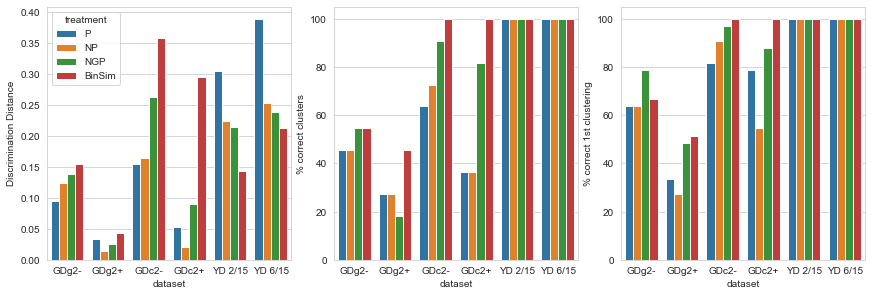

In [62]:
p4 = sns.color_palette('tab10', 4)
with sns.axes_style("whitegrid"):
    f, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=HCA_performance_MinBinSim, ax=axs[0], palette=p4)
    sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=HCA_performance_MinBinSim, ax=axs[1], palette=p4)
    sns.barplot(x="dataset", y="% correct 1st clustering", hue="treatment", data=HCA_performance_MinBinSim, ax=axs[2], palette=p4)
    axs[1].legend().set_visible(False)
    axs[2].legend().set_visible(False)
    plt.show()

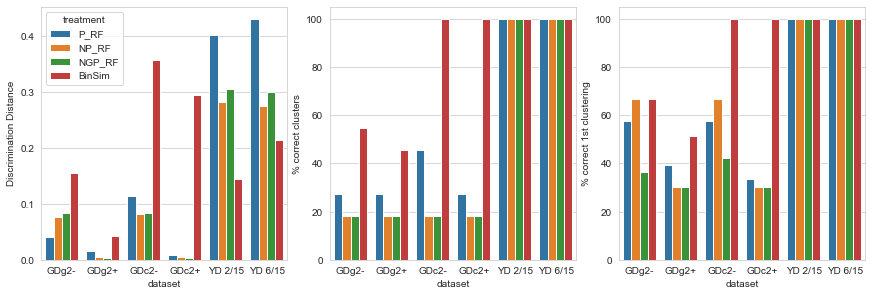

In [64]:
p4 = sns.color_palette('tab10', 4)
with sns.axes_style("whitegrid"):
    f, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=HCA_performance_RFBinSim, ax=axs[0], palette=p4)
    sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=HCA_performance_RFBinSim, ax=axs[1], palette=p4)
    sns.barplot(x="dataset", y="% correct 1st clustering", hue="treatment", data=HCA_performance_RFBinSim, ax=axs[2], palette=p4)
    axs[1].legend().set_visible(False)
    axs[2].legend().set_visible(False)
    plt.show()

## K-means Clustering Analysis

K-means clustering analysis was applied by using the appropriate functions of the scikit-learn as done in the following cells.

#### K-means clustering was applied to all the 4 differently-treated data sets for each of the 6 benchmark data sets

The number of clusters chosen was equal to the amount of groups. Apart from this, default parameters were used (Euclidian distance was used for the BinSim case since in this method, binary distance metrics can't be used).

K-means clustering analysis has an intrinsically random side to it depending on the starting position of the clusters centroids and due to the existence of local minima. Due to this randomness, the algorithm was repeated 15 (n) times and the result with the least inertia (greater minimization of the objective function - sum of squared distances of the samples to the cluster centroids) was retained (best 10% of results, in this case, only the best).

To evaluate the discrimination achieved with each K-means Clustering, 3 different metrics were used (explained in the paper):

- **Discrimination Distance** (for K-means clustering, identical idea to HCA)
- **Correct Clustering Percentage** (for K-means clustering, identical idea to HCA)
- **Adjusted Rand Index** (calculated by scikit-learn - `adjusted_rand_index`) - proportion of sample pairs which are correctly clustered or correctly not clustered, adjusted for the expected percentage of samples which would be in those situations randomly.

The function `Kmeans_discrim` from multianalysis.py was applied to calculate these metrics with explanations of each step to calculate the different metrics.

Correct clustering definition - K-means Cluster contains all and only the samples of a single group (stricter definition than in HCA). Samples of a group can all be together in a cluster, but if another sample (of another group) is present, the group is not correctly clustered. Thus, the Correct Clustering Percentage is expected to be lower in this case.

In this case, the distances are calculated by the distance between different cluster centroids.

In [65]:
import sklearn.cluster as skclust
from sklearn.metrics import adjusted_rand_score

In [66]:
def perform_KMeans(dataset, treatment, iter_num=150, best_fraction=0.1):
    "Perform K-means Clustering Analysis and calculate discrimination evaluation metrics."
    
    sample_labels = datasets[dataset]['target']
    n_classes = len(pd.unique(sample_labels))
    
    df = datasets[dataset][treatment]
    
    discrim = ma.Kmeans_discrim(df, sample_labels,
                                method='average', 
                                iter_num=iter_num,
                                best_fraction=best_fraction)

    
    # Lists for the results of the best k-means clustering
    average = []
    correct = []
    rand = []
    
    for j in discrim:
        global_disc_dist, disc_dists, rand_index, SSE = discrim[j]
        
        # Average of discrimination distances
        average.append(global_disc_dist) 
        
        # Correct Clustering Percentages
        all_correct = np.array(list(disc_dists.values()))
        correct.append(len(all_correct[all_correct>0]))
        
        # Adjusted Rand Index
        rand.append(rand_index) 
    
    return{'dataset': dataset,
           'treatment': treatment,
           'Discrimination Distance': np.median(average),
           '% correct clusters':np.median(correct)*100/n_classes,
           'Rand Index': np.median(rand)}

In [67]:
# NOTE: for debugging
iter_num=15
# otherwise
#iter_num=150

KMeans_all = []

for dsname in ('GD_neg_global2', 'GD_pos_global2', 'GD_neg_class2', 'GD_pos_class2', 'YD', 'YD2'):
    for treatment in ('P', 'NP', 'NGP', 'P_RF', 'NP_RF', 'NGP_RF', 'BinSim'):
        print(f'performing KMeans on {dsname} with treatment {treatment}' , end=' ...')
        KMeans_all.append(perform_KMeans(dsname, treatment, iter_num=iter_num))
        print('done!')        

performing KMeans on GD_neg_global2 with treatment P ...done!
performing KMeans on GD_neg_global2 with treatment NP ...done!
performing KMeans on GD_neg_global2 with treatment NGP ...done!
performing KMeans on GD_neg_global2 with treatment P_RF ...done!
performing KMeans on GD_neg_global2 with treatment NP_RF ...done!
performing KMeans on GD_neg_global2 with treatment NGP_RF ...done!
performing KMeans on GD_neg_global2 with treatment BinSim ...done!
performing KMeans on GD_pos_global2 with treatment P ...done!
performing KMeans on GD_pos_global2 with treatment NP ...done!
performing KMeans on GD_pos_global2 with treatment NGP ...done!
performing KMeans on GD_pos_global2 with treatment P_RF ...done!
performing KMeans on GD_pos_global2 with treatment NP_RF ...done!
performing KMeans on GD_pos_global2 with treatment NGP_RF ...done!
performing KMeans on GD_pos_global2 with treatment BinSim ...done!
performing KMeans on GD_neg_class2 with treatment P ...done!
performing KMeans on GD_neg_cla

In [68]:
KMeans_all = pd.DataFrame(KMeans_all)
#cv_dsnames = {'GD_neg_global2': 'global2 -',
              #'GD_pos_global2': 'global2 +',
              #'GD_neg_class2': 'class2 -',
              #'GD_pos_class2': 'class2 +',
              #'YD': 'YD'}
cv_dsnames = {name:datasets[name]['name'] for name in datasets}
KMeans_all2 = KMeans_all.assign(dataset = KMeans_all['dataset'].map(cv_dsnames))

In [69]:
KMeans_all2

,dataset,treatment,Discrimination Distance,% correct clusters,Rand Index
0,GDg2-,P,0.085151,18.181818,0.481508
1,GDg2-,NP,0.107849,22.727273,0.431716
2,GDg2-,NGP,0.139005,27.272727,0.527600
3,GDg2-,P_RF,0.036376,9.090909,0.384768
4,GDg2-,NP_RF,0.004329,4.545455,0.400108
5,GDg2-,NGP_RF,0.038068,9.090909,0.292035
6,GDg2-,BinSim,0.189282,31.818182,0.549261
7,GDg2+,P,0.000000,0.000000,0.215548
8,GDg2+,NP,0.034812,22.727273,0.485554
9,GDg2+,NGP,0.000000,0.000000,0.314607


Results summary

In [70]:
KMeans_performance_MinBinSim = KMeans_all2[KMeans_all2['treatment'].isin(['P', 'NP', 'NGP', 'BinSim'])]
KMeans_performance_RFBinSim = KMeans_all2[KMeans_all2['treatment'].isin(['P_RF', 'NP_RF', 'NGP_RF', 'BinSim'])]

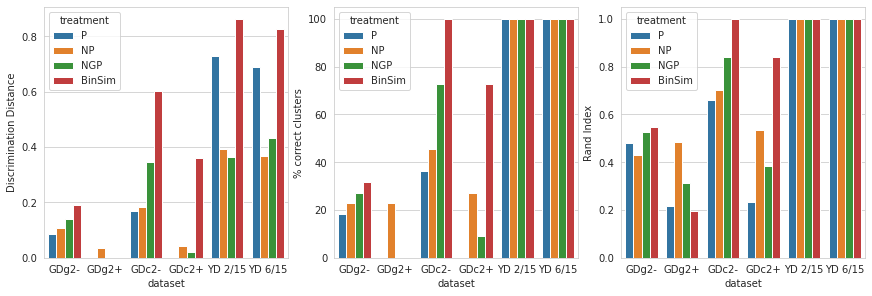

In [71]:
p4 = sns.color_palette('tab10', 4)
with sns.axes_style("whitegrid"):
    f, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=KMeans_performance_MinBinSim, ax=axs[0], palette=p4)
    sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=KMeans_performance_MinBinSim, ax=axs[1], palette=p4)
    sns.barplot(x="dataset", y="Rand Index", hue="treatment", data=KMeans_performance_MinBinSim, ax=axs[2], palette=p4)

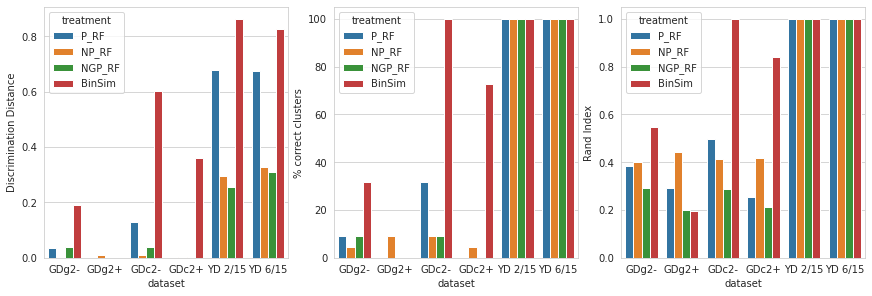

In [72]:
p4 = sns.color_palette('tab10', 4)
with sns.axes_style("whitegrid"):
    f, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=KMeans_performance_RFBinSim, ax=axs[0], palette=p4)
    sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=KMeans_performance_RFBinSim, ax=axs[1], palette=p4)
    sns.barplot(x="dataset", y="Rand Index", hue="treatment", data=KMeans_performance_RFBinSim, ax=axs[2], palette=p4)

## Summary of Clustering performance

HCA and K-means Clustering results combined.

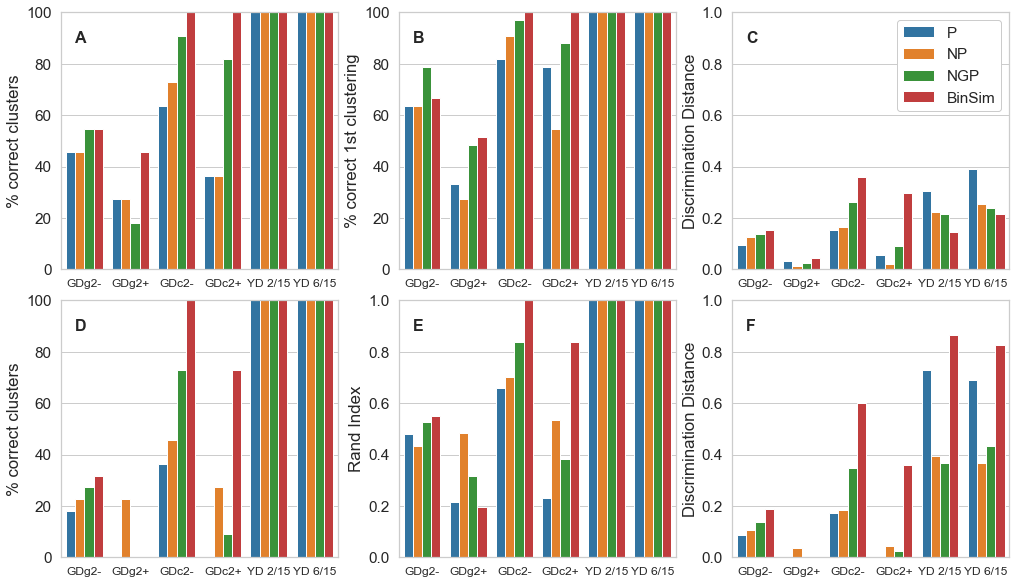

In [73]:
p4 = sns.color_palette('tab10', 4)
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, axs = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
        sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=HCA_performance_MinBinSim, ax=axs[0][2], palette=p4)
        sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=HCA_performance_MinBinSim, ax=axs[0][0], palette=p4)
        sns.barplot(x="dataset", y="% correct 1st clustering", hue="treatment", data=HCA_performance_MinBinSim, ax=axs[0][1], palette=p4)

        sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=KMeans_performance_MinBinSim, ax=axs[1][2], palette=p4)
        sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=KMeans_performance_MinBinSim, ax=axs[1][0], palette=p4)
        sns.barplot(x="dataset", y="Rand Index", hue="treatment", data=KMeans_performance_MinBinSim, ax=axs[1][1], palette=p4)
        for i, ax in enumerate(axs.ravel()):
            ax.set_ylim(0,100)
            ax.xaxis.label.set_visible(False)
            ax.legend().set_visible(False)
            ax.tick_params(axis='x', which='major', labelsize=12)
        #axs[0][1].set_title('HCA', fontsize=15)
        #axs[1][1].set_title('KMeans', fontsize=15)
        axs[0][2].legend(bbox_to_anchor=(1,1), loc="upper right", framealpha=1)
        axs[1][2].set_ylim(0,1.0)
        axs[0][2].set_ylim(0,1)
        axs[1][1].set_ylim(0,1)
        
        for letter, ax in zip('ABCDEFGHIJ', axs.ravel()):
            ax.text(0.05, 0.9, letter, ha='left', va='center', fontsize=16, weight='bold',
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', edgecolor='white', alpha=0.9))

        plt.show()

        f.savefig('paperimages/clust_performance.pdf' , dpi=200)
        f.savefig('paperimages/clust_performance.png' , dpi=600)
        f.savefig('paperimages/clust_performance.svg')

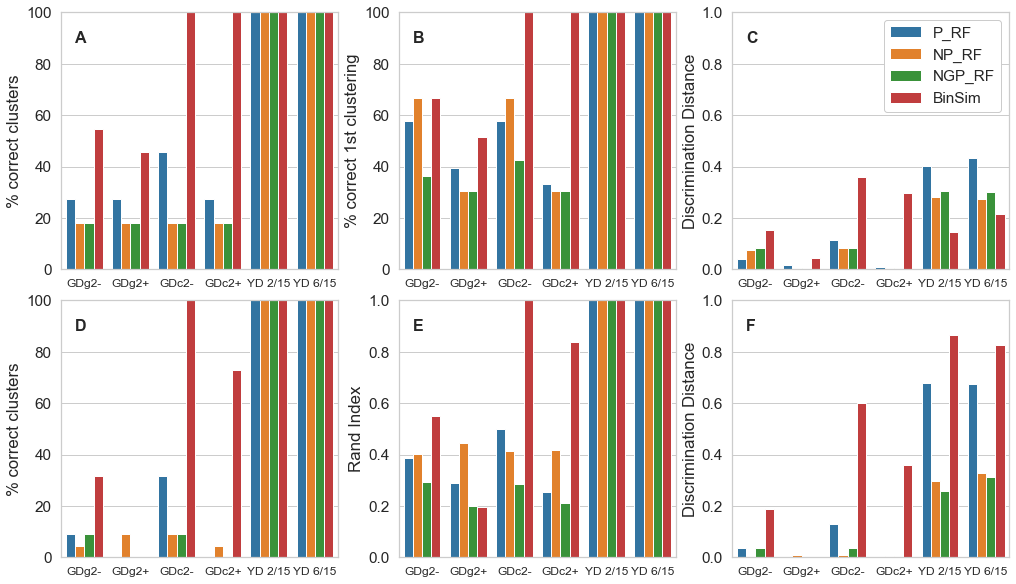

In [74]:
p4 = sns.color_palette('tab10', 4)
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, axs = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
        sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=HCA_performance_RFBinSim, ax=axs[0][2], palette=p4)
        sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=HCA_performance_RFBinSim, ax=axs[0][0], palette=p4)
        sns.barplot(x="dataset", y="% correct 1st clustering", hue="treatment", data=HCA_performance_RFBinSim, ax=axs[0][1], palette=p4)

        sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=KMeans_performance_RFBinSim, ax=axs[1][2], palette=p4)
        sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=KMeans_performance_RFBinSim, ax=axs[1][0], palette=p4)
        sns.barplot(x="dataset", y="Rand Index", hue="treatment", data=KMeans_performance_RFBinSim, ax=axs[1][1], palette=p4)
        for i, ax in enumerate(axs.ravel()):
            ax.set_ylim(0,100)
            ax.xaxis.label.set_visible(False)
            ax.legend().set_visible(False)
            ax.tick_params(axis='x', which='major', labelsize=12)
        #axs[0][1].set_title('HCA', fontsize=15)
        #axs[1][1].set_title('KMeans', fontsize=15)
        axs[0][2].legend(bbox_to_anchor=(1,1), loc="upper right", framealpha=1)
        axs[1][2].set_ylim(0,1.0)
        axs[0][2].set_ylim(0,1)
        axs[1][1].set_ylim(0,1)
        
        for letter, ax in zip('ABCDEFGHIJ', axs.ravel()):
            ax.text(0.05, 0.9, letter, ha='left', va='center', fontsize=16, weight='bold',
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', edgecolor='white', alpha=0.9))

        plt.show()

        f.savefig('paperimages/clust_performance_rf.pdf' , dpi=200)
        f.savefig('paperimages/clust_performance_rf.png' , dpi=600)
        f.savefig('paperimages/clust_performance_rf.svg')